In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib 

# Dataload

In [3]:
df = pd.read_json('/fastcampus-data/select_column_version_4.json')

## 전체 기간

In [4]:
df['date_paid'] = pd.to_datetime(df['date_paid'])
df['date_paid'].min(), df['date_paid'].max()

(Timestamp('2019-08-26 02:41:49.950000+0000', tz='UTC'),
 Timestamp('2022-09-13 08:59:21.151000+0000', tz='UTC'))

In [5]:
df['date_paid'].max() - df['date_paid'].min()

Timedelta('1114 days 06:17:31.201000')

# 전체 카테고리 판매율

In [6]:
sum_ = df['name'].value_counts().head(10).sum()
product_ct = pd.DataFrame(df['name'].value_counts()).rename(columns={'name':'Counts'})
product_ratio = pd.DataFrame(round(df['name'].value_counts() / sum_, 3)).rename(columns={'name':'Ratio'})
category_count = pd.concat([product_ct, product_ratio], axis = 1)
category_count.sort_values(by='Ratio', ascending=False).head(10)

,Counts,Ratio
온라인 강의,73262,0.319
도서,54422,0.237
소모품,34400,0.150
한약재,22944,0.100
의료기기,12784,0.056
의약품,10071,0.044
식품,8374,0.036
의류/잡화,5331,0.023
치료실 물품,3979,0.017
가전/가구,3962,0.017


**카테고리별 판매 순위**

* 온라인 강의 > 도서 > 소모품 > 한약재 > 의료기기 > 의약품 > ..    
* 전체 카테고리 중 도서 판매 비율이 2위이다. 마켓에서 도서를 사는 사람이 상대적으로 많다고 볼 수있다.

In [7]:
# 전역 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (17,8)

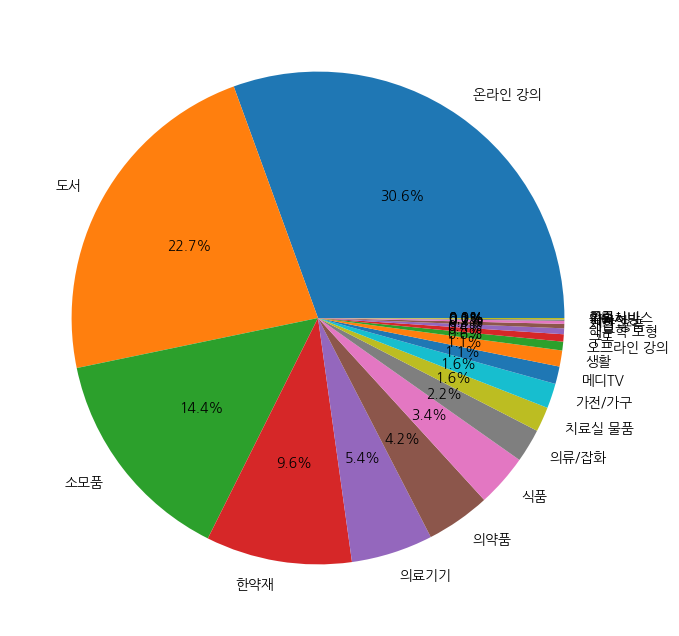

In [8]:
labels = category_count.index

plt.pie(category_count['Ratio'].values, labels = labels, autopct='%.1f%%')
plt.show()

## filtering: 도서 구매 데이터 EDA
* 취소되지 않은 paid가 완전히 이루어진 구매기록만 사용
* 도서 카테고리만 사용
* 한 유저가 중복으로 구매한 아이템 제거

In [9]:
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]

# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]

# 도서 카테고리만 가져오기
only_book = complete_df[complete_df['name'] == '도서']

# 유저가 중복으로 아이템 구매 삭제
df_duplicated_book = only_book.drop_duplicates(subset=['customer_id','product_ids'])
df_book = df_duplicated_book.sort_values(by='date_paid').reset_index(drop=True)

In [10]:
# none 값 확인
df_book.isna().sum()

_id                 0
date_created        0
regular_price       0
sale_price          0
three_months        0
date_paid           0
customer_id         0
paid                0
name_x              0
category_id_y       0
product_ids         0
quantity            0
price               0
price_total         0
age_group        3007
한의사 여부             79
사업자 여부             79
cancelled           0
name                0
slug                0
dtype: int64

### 데이터 중복 확인

In [11]:
# product_ids, name_x 일치하지 않음, 전처리 필요
len(df_book.product_ids.unique()), len(df_book.name_x.unique())

(342, 370)

In [12]:
# 중복 제거 후 수 비교 확인
len(df_book.drop_duplicates(subset=['product_ids','name_x']).name_x.unique())

370

product_id보다 name이 더 많다. 즉, 동일한 id의 가진 제품의 이름이 다른 경우가 있다는 의미이다. 

같은 id를 가진 제품은 모두 동일한 이름을 갖도록 전처리한다.

In [13]:
product_name_preprocess_df = df_book.copy()

In [14]:
# 각 마지막 product_ids, name으로 채우기
product_ids_to_name = {}
for idx, row in product_name_preprocess_df.iterrows():
    product_ids_to_name[row.product_ids] = row.name_x
product_name_preprocess_df['name_x'] = product_name_preprocess_df['product_ids'].apply(lambda x: product_ids_to_name[x])

name_to_product_ids = {}
for idx, row in product_name_preprocess_df.iterrows():
    name_to_product_ids[row.name_x] = row.product_ids
product_name_preprocess_df['product_ids'] = product_name_preprocess_df['name_x'].apply(lambda x: name_to_product_ids[x])

In [15]:
# product_ids, name_x 일치 확인
len(product_name_preprocess_df.product_ids.unique()), len(product_name_preprocess_df.name_x.unique())

(340, 340)

In [16]:
# name, product 전처리에 따라서 다시 중복 제거
df_reduplicated_book = product_name_preprocess_df.drop_duplicates(subset=['customer_id','product_ids'])
preprocessed_book_df = df_reduplicated_book.sort_values(by='date_paid').reset_index(drop=True)

### 데이터 수 확인

In [17]:
print('전체 유저 수:',len(set(preprocessed_book_df.customer_id)))
print('전체 아이템 수:', len(set(preprocessed_book_df.product_ids)))

전체 유저 수: 7410
전체 아이템 수: 340


전체 유저 수 대비 책을 구매한 유저의 비율이다.  
약 1.5%로 매우 낮은 편에 속한다.

In [22]:
# 전체 구매 백분율
len(preprocessed_book_df)/(len(set(preprocessed_book_df.customer_id))*len(set(preprocessed_book_df.product_ids)))

0.015028578232912598

In [19]:
print('유저 최대 구매 횟수:',preprocessed_book_df.customer_id.value_counts().max())
print('유저 중간 구매 횟수:',preprocessed_book_df.customer_id.value_counts().median())
print('유저 최소 구매 횟수:',preprocessed_book_df.customer_id.value_counts().min())

유저 최대 구매 횟수: 130
유저 중간 구매 횟수: 3.0
유저 최소 구매 횟수: 1


# 고객 segment별 나이 비율

In [20]:
# 원장님
ceo_doctor = df[(df['한의사 여부'] == 1.0) & (df['사업자 여부'] == 1.0)]

# 페이 닥터
pay_doctor = df[(df['한의사 여부'] == 1.0) & (df['사업자 여부'] == 0.0)]

# 한의대생
student = df[(df['한의사 여부'] == 0.0) & (df['사업자 여부'] == 0.0)]

# 창업가?
ceo = df[(df['한의사 여부'] == 0.0) & (df['사업자 여부'] == 1.0)]

all = [ceo, ceo_doctor, student, pay_doctor]


print('고객 segment별 나이 비율: ')
print()
all = [ceo_doctor, pay_doctor, ceo, student]
all2 = ['ceo_doctor', 'pay_doctor', 'ceo', 'student']

for i in range(len(all)):
    print(f'[{all2[i]}]')
    a = all[i].age_group.value_counts().sum()
    print(round(all[i].age_group.value_counts() / a, 2))
    print()

고객 segment별 나이 비율: 

[ceo_doctor]
30-39    0.55
40-49    0.25
20-29    0.11
50-59    0.08
60-      0.01
Name: age_group, dtype: float64

[pay_doctor]
20-29    0.62
30-39    0.31
40-49    0.06
50-59    0.02
60-      0.00
0-9      0.00
Name: age_group, dtype: float64

[ceo]
30-39    0.65
20-29    0.17
40-49    0.17
50-59    0.01
Name: age_group, dtype: float64

[student]
20-29    0.84
30-39    0.13
40-49    0.02
50-59    0.01
60-      0.00
10-19    0.00
0-9      0.00
Name: age_group, dtype: float64



**병원장(ceo_doctor)을 제외한 모든 segment에서 2030의 비율이 제일 높다.**

# 고객별 누적 판매횟수

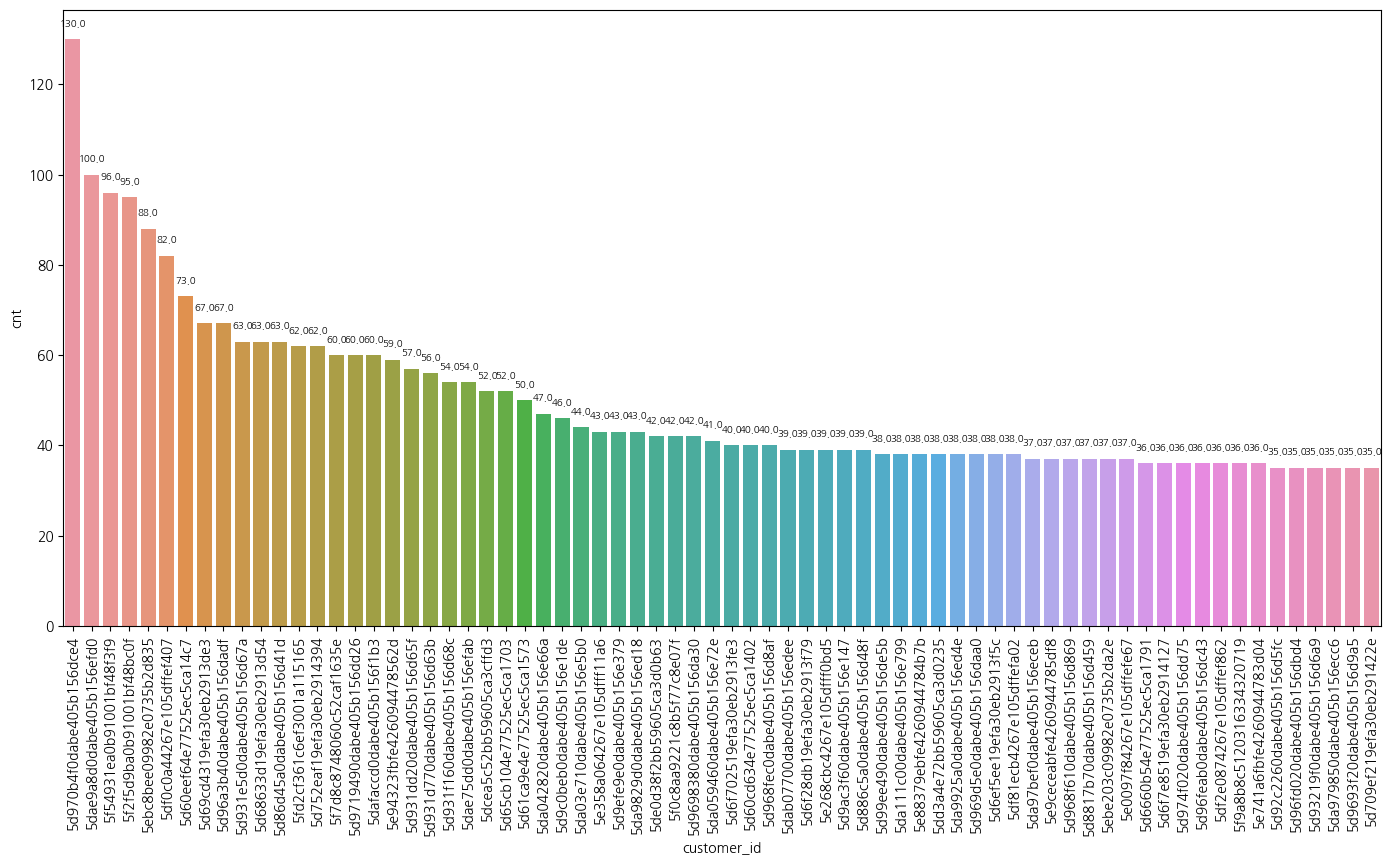

In [24]:
before_user_group_df = df_book.groupby('customer_id')[['customer_id']].count().rename(columns={'customer_id':'cnt'}).reset_index().sort_values(by='cnt',ascending=False).head(70)

ax = sns.barplot(data=before_user_group_df, x='customer_id',y='cnt')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 7)
plt.show()

In [25]:
# 전체 유저의 구매 빈도
df_book.groupby('customer_id')[['customer_id']].count().rename(columns={'customer_id':'cnt'}).reset_index().sort_values(by='cnt',ascending=False).describe()

,cnt
count,7410.000000
mean,5.110121
std,6.993800
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,130.000000


In [26]:
print('유저 최대 누적 구매 횟수:',before_user_group_df.max())
print('유저 median 누적 구매 횟수:',before_user_group_df.median())

유저 최대 누적 구매 횟수: customer_id    5fd2cf361c6ef3001a115165
cnt                                 130
dtype: object
유저 median 누적 구매 횟수: cnt    40.5
dtype: float64


# 날짜별 구매량 시각화

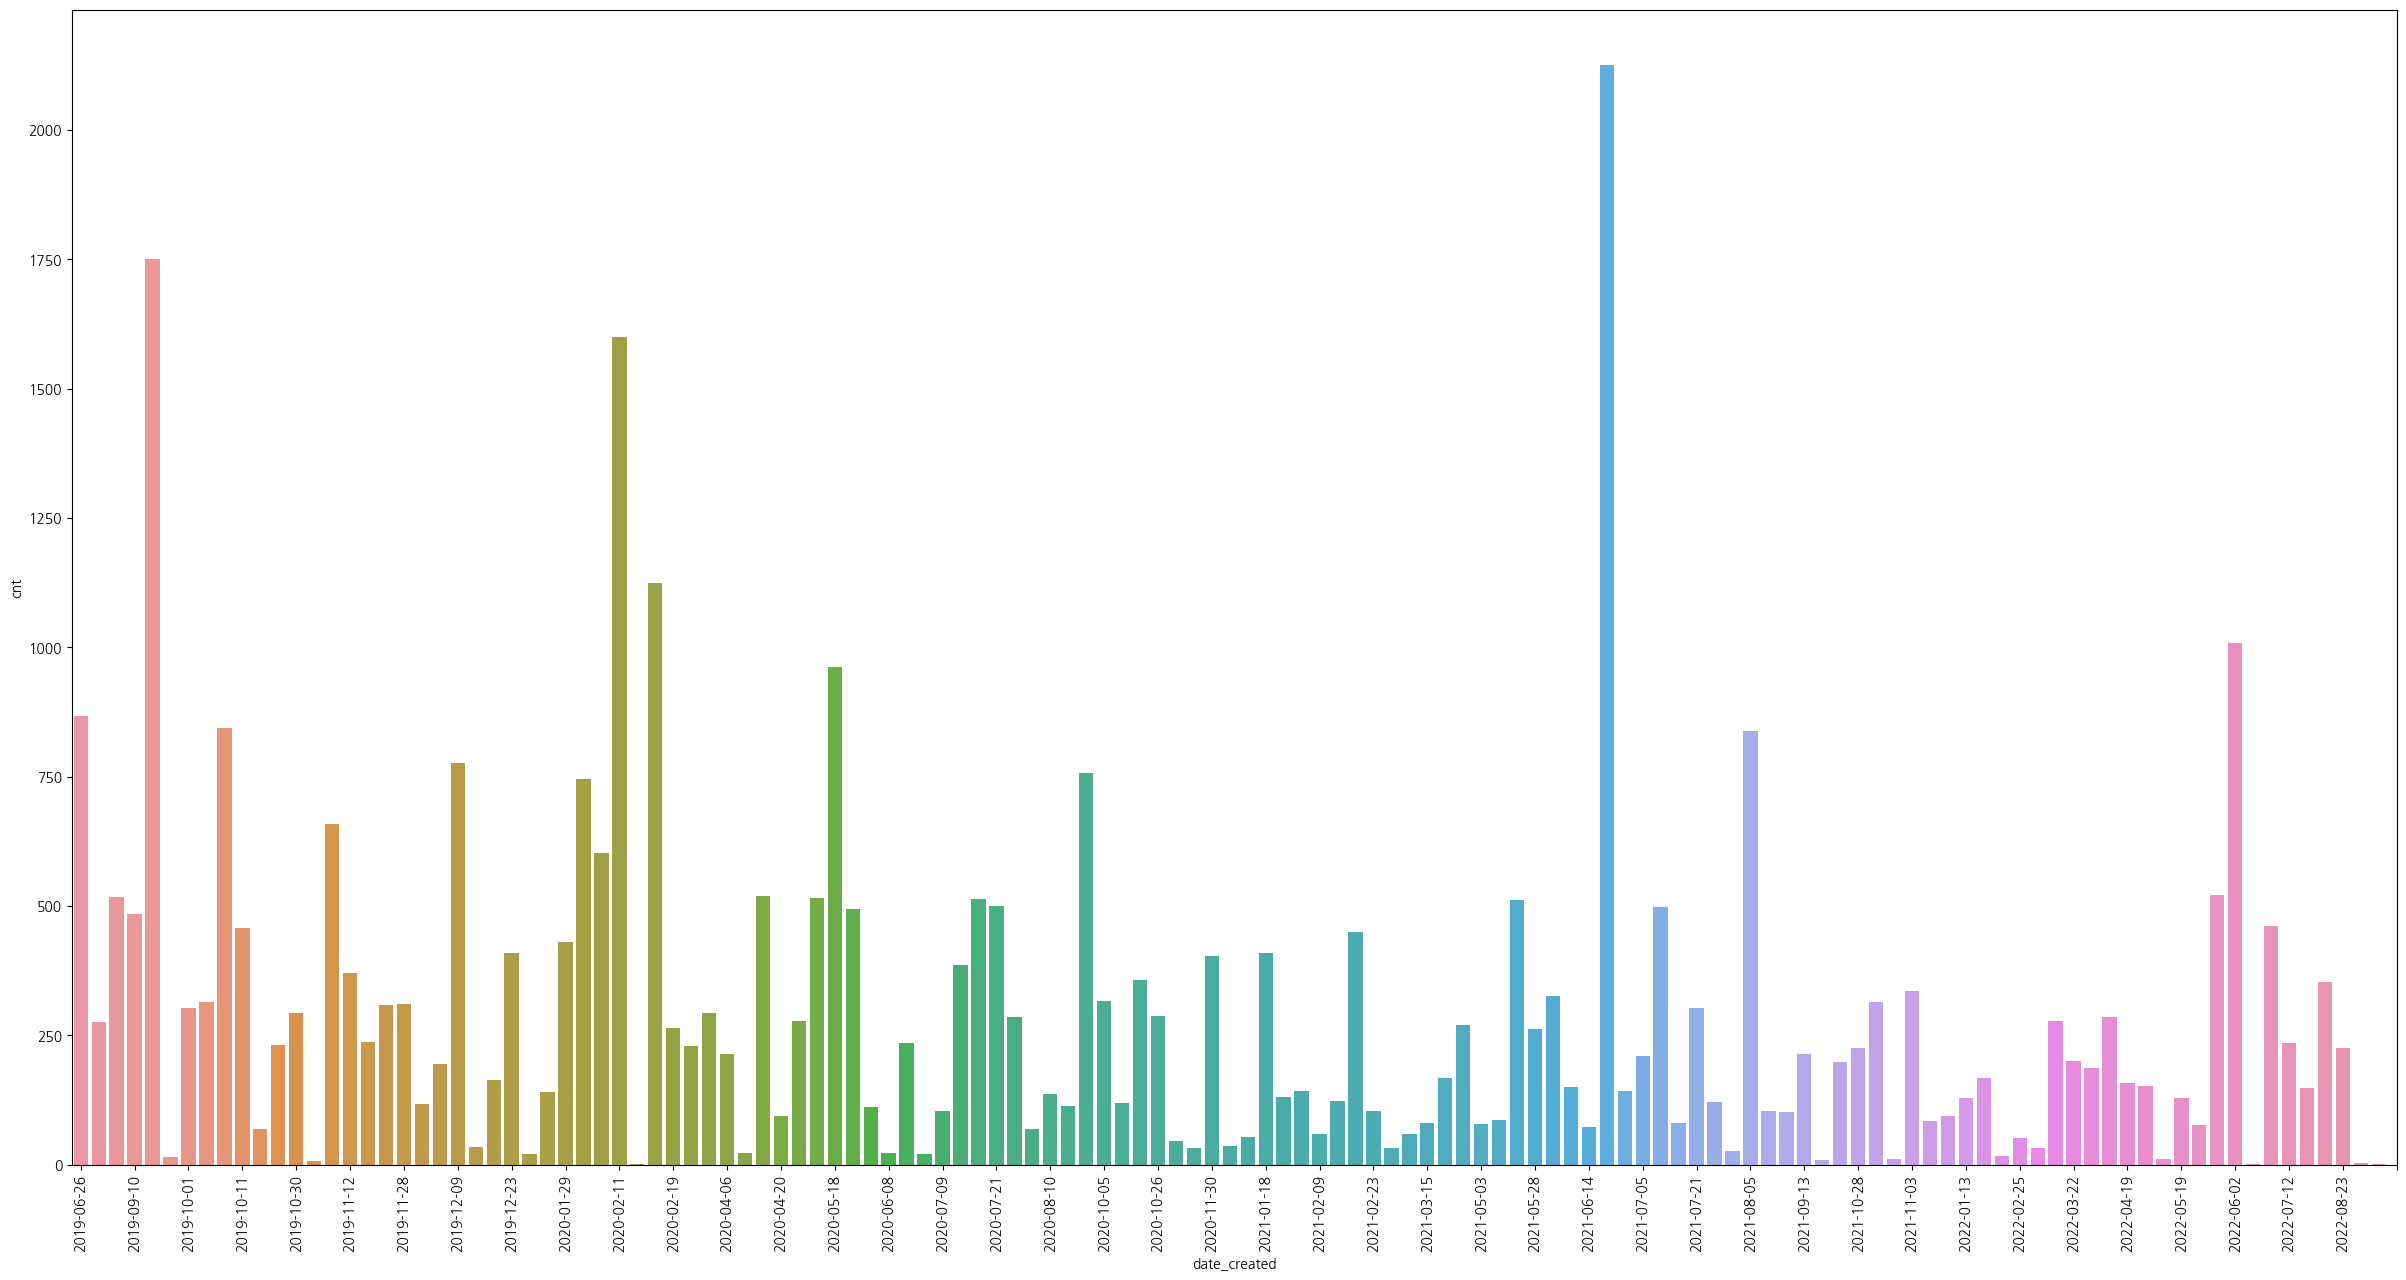

In [27]:
from datetime import datetime,date
preprocessed_book_df['date_created'] = pd.to_datetime(preprocessed_book_df['date_created']).dt.date

dat_groupby = preprocessed_book_df.groupby(['date_created'])[['product_ids']].count().reset_index().rename(columns={'product_ids':'cnt'})
dat_sort = dat_groupby.sort_values(by='date_created')

x = dat_sort['date_created']
y = dat_sort['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 3))
plt.xticks(rotation=90)
plt.show()

* 특정 일자에 갑자기 구매량이 급격히 증가하는 현상을 보임
* 주마다 도서에 대한 프로모션을 진행하는 것을 확인

    -> 프로모션에 의한 구매는 제거하는 것 고려

In [28]:
dat_sort.describe()

,cnt
count,129.000000
mean,293.511628
std,334.229527
min,1.000000
25%,85.000000
50%,210.000000
75%,371.000000
max,2126.000000


In [29]:
dat_sort.sort_values(['cnt'], ascending = False).head(10)

,date_created,cnt
85,2021-06-21,2126
4,2019-09-11,1750
30,2020-02-11,1600
32,2020-02-18,1125
120,2022-06-02,1008
42,2020-05-18,961
0,2019-06-26,868
8,2019-10-10,844
93,2021-08-05,838
21,2019-12-09,776


# Best Seller(promotion 구매 포함)

**전체기간 Best Seller**

In [30]:
bestseller_count_series = df_book['name_x'].value_counts().head(20)
bestseller_count_df = pd.DataFrame(bestseller_count_series.reset_index().rename(columns={'index':'name','name_x':'counts'}))
bestseller_count_df['percentage'] = bestseller_count_df['counts']/len(df_book)
bestseller_count_df

,name,counts,percentage
0,윤상훈·권병조의 알짜 근육학,2126,0.056145
1,KCD 한방내과 진찰진단 가이드라인,805,0.021259
2,한의 피부진료 첫 걸음,776,0.020493
3,사상방 사용설명서,757,0.019992
4,그림과 사진으로 보는 질환별 통증치료 Essential,658,0.017377
5,비만문답,592,0.015634
6,한방처방정석,520,0.013733
7,일차진료 한의사를 위한 보험한약입문 - 둘째 판,517,0.013653
8,사진으로 공부하는 이비인후과학,516,0.013627
9,통장잔고 2배 늘려주는 병의원 절세비법,512,0.013521


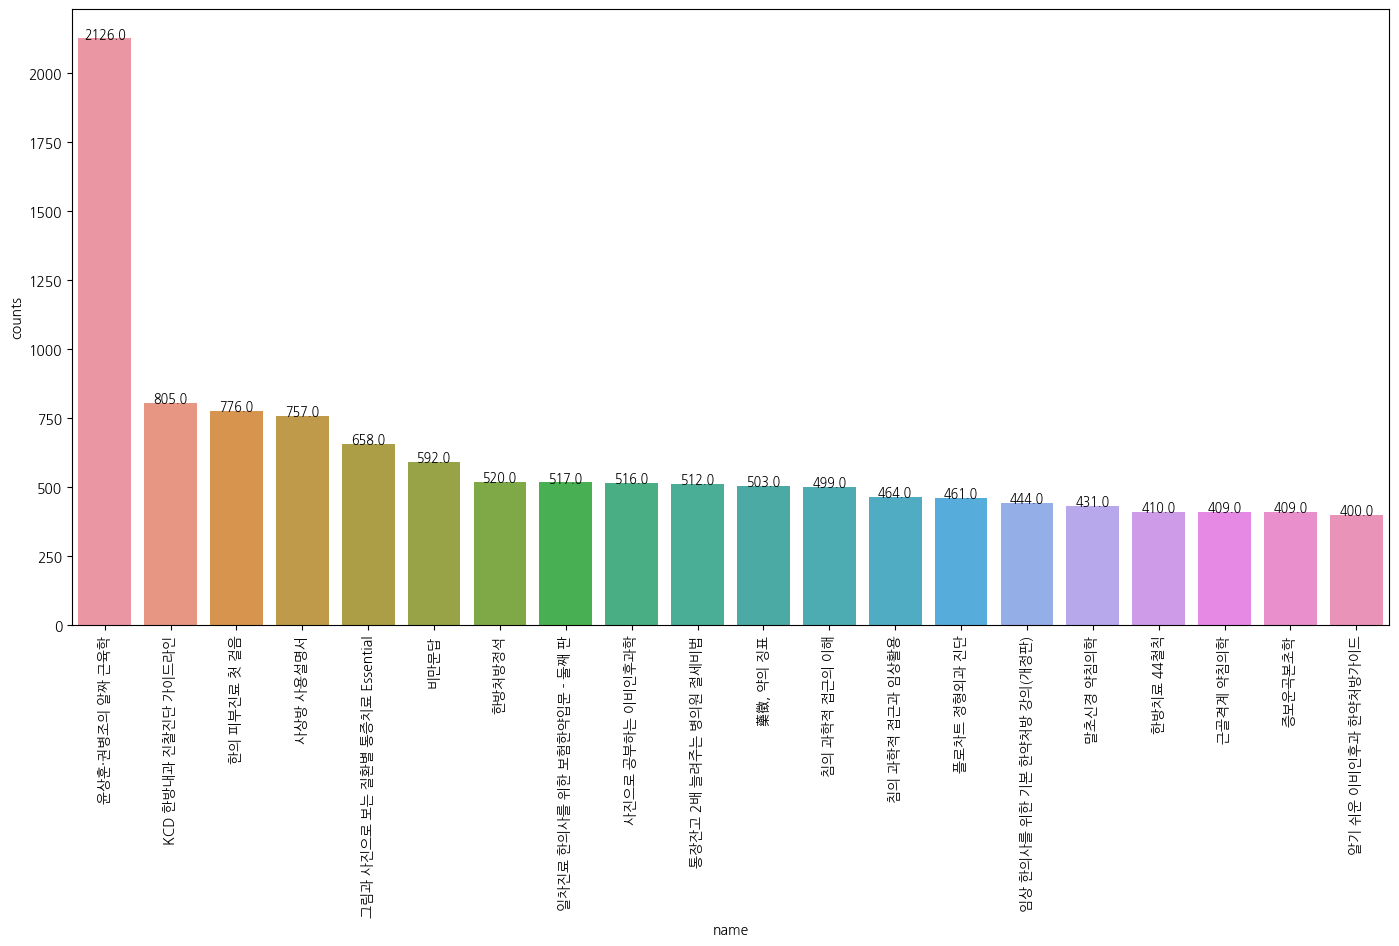

In [31]:
ax = sns.barplot(data=bestseller_count_df, x='name',y='counts')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

In [32]:
# bestseller 비율
print('bestseller 구매 비율:', round(bestseller_count_series.sum()/len(df_book), 4))

bestseller 구매 비율: 0.3224


# Best Seller(promotion 제외)

메디스트림에 확인결과, 도서 판매 촉진을 위해 매주 프로모션을 진행하고 있었다. 프로모션 대상 아이템은 매주 다르다.   
최근 1년 동안의 프로모션 아이템 리스트를 제공받아 대상 아이템을 구매기록에서 제외하고 분석을 진행했다.

### 프로모션 전처리

In [33]:
def promotion_proprof(df):
    from datetime import datetime

    preprocessed_book_df_date = df.copy()

    promotion_book_df = preprocessed_book_df_date[preprocessed_book_df_date['date_paid'] >= '2022-01-01']
    promotion_book_df['date_paid_date'] = promotion_book_df['date_paid'].dt.date
    promotion_book_df['date_paid_week'] = promotion_book_df['date_paid_date'].apply(lambda x: x.isocalendar()[1])

    # 주차별 프로모션 대상 도서를 리스트에 담기
    promotion_dict = {
        2:['트리거포인트 침치료'],
        3:['藥徵, 약의 징표','파킨슨병 한의진료','침의 과학적 접근의 이해','길익동동','Medical acupuncture 침의 과학적 접근과 임상활용',\
          '동의보감 약선','수화론(水火論)'],
        4:['실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리'],
        5:['음양승강으로 해석하는 사상의학: 생리병리'],
        6:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','트리거포인트 침치료','KCD 한방내과 진찰진단 가이드라인',\
          '실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리','藥徵, 약의 징표','증보운곡본초학','통증치료를 위한 근육 초음파와 주사 테크닉'],
        7:['오국통 온병명방'],
        9:['병태생리 Visual map','NEO 인턴 핸드북','보험한약 브런치 the # 2판 개정판','Kendall 자세와 통증치료에 있어서 근육의 기능과 검사 5판',\
          '사상방 사용설명서','실전한약가이드','일차진료 한의사를 위한 보험한약입문 - 둘째 판','증보운곡본초학'],
        10:['한눈에 보는 스트레칭 해부학'],
        11:['임산부에게 사용할 수 있는 한방처방'],
        12:['임산부에게 사용할 수 있는 한방처방'],
        13:['MRI 자신감 키우기_족부편'],
        14:['장골의 PI 변위는 없다'],
        15:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','KCD 한방내과 진찰진단 가이드라인','트리거포인트 침치료',\
           '음양승강으로 해석하는 사상의학: 생리병리','침의 과학적 접근의 이해','실전한약가이드','임산부에게 사용할 수 있는 한방처방','한눈에 보는 스트레칭 해부학',\
           'MRI 자신감 키우기_족부편'],
        16:['환자상담의 달인','병의원 경영과 자산 관리 클리닉','우리 병원의 문제? 현장에서 답을 찾다!','근육학','스파이랄 및 키네지오 테이핑',\
           '요양병원 주치의 진료핵심'],
        17:['오당 본초강론','운동기능장애 치료 매뉴얼','K. 한의학 임상총론','한방 활용 가이드','최강통증매선','암 치료에 이용되는 천연약물',\
           '왕문원 임상 평형침법','중국 왕문원 평형침구학'],
        18:['초음파 가이드 근골격계 통증 치료의 정석'],
        19:['초음파 가이드 근골격계 통증 치료의 정석','섭혜민 명의경방험안'],
        20:['카이로프랙틱 기본테크닉론'],
        21:['흔히보는 정형외과 외래진료 가이드북'],
        22:['趙紹琴(조소금) 내과학','한의학 상담','숨찬 세상, 호흡기를 편하게',\
         '의학심오(醫學心悟)','안면마비 침구치료','중경서 독법 강해(상,하) /개정판'],
        23:['선생님, 이제 그만 저 좀 포기해 주세요','한의학 상담','숨찬 세상, 호흡기를 편하게',\
        '의학심오(醫學心悟)','중경서 독법 강해(상,하) /개정판','안면마비 침구치료'],
     24:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼','황황교수의 개원 한의사를 위한 상한금궤 처방 강의록',\
        '선생님, 이제 그만 저 좀 포기해 주세요'],\
     25:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼',\
       '황황교수의 개원 한의사를 위한 상한금궤 처방 강의록','약침의 정석 –통증편','갑상선 진료 완전정복',\
       '신경학 증상의 감별법','이것이 알고싶다! 당뇨병진료','어지럼질환의 진단과 치료','증례와 함께 하는 한약처방',\
       '뇌의학의 첫걸음','HAPPY 소아청소년 진료'],\
     26:['약침의 정석 –통증편','갑상선 진료 완전정복','신경학 증상의 감별법',\
       '증례와 함께 하는 한약처방','이것이 알고싶다! 당뇨병진료','HAPPY 소아청소년 진료','어지럼질환의 진단과 치료',\
       '뇌의학의 첫걸음','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','침구대성','평주온열경위'],
     27:['침구과 진료매뉴얼','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','내과학 5권세트','한방순환 신경내과학',\
        '침구대성'],
     28:['감별진단의 정석','기본통증진료학','약처방의 정석 (1, 2권 세트)','QBook: Case based Review',\
         'SMART 내과 1권 : 바이탈, 감염, 종양, 류마티스','일차진료아카데미 처방가이드'],
     29:['비만문답','사암침의 해석과 임상'],
     30:['플로차트 정형외과 진단','침구과 진료매뉴얼','내과학 5권세트','한방순환 신경내과학'],
     31:['외래에서 꼭 알아야 할 통증증후군 137가지'],
     32:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
     33:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
     34:['초음파 유도하 침 시술 가이드북'],
     35:['영어 진료 가이드북','초음파 유도하 침 시술 가이드북'],
     36:['영어 진료 가이드북','소아피부질환해설'],
     37:['소아피부질환해설','醫學心悟(의학심오) 톺아보기'],}

    promotion_item_list = []
    for promotion_items in promotion_dict.values():
        for item in promotion_items:
            promotion_item_list.append(item)

    # set(promotion_item_list), len(set(promotion_item_list))

    preprocess_promotion_df = promotion_book_df[~((promotion_book_df['name_x'].str.contains('침의 과학적 접근과 임상활용')) & \
                            (promotion_book_df['date_paid_week']==3))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==22))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==23))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('약처방의 정석')) & \
                                (preprocess_promotion_df['date_paid_week']==28))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                                (preprocess_promotion_df['date_paid_week']==34))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                                (preprocess_promotion_df['date_paid_week']==34))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                                (preprocess_promotion_df['date_paid_week']==35))]
    preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                                (preprocess_promotion_df['date_paid_week']==36))]
    all_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                                (preprocess_promotion_df['date_paid_week']==37))]

    for key,value in promotion_dict.items():
        all_promotion_df = all_promotion_df[~((all_promotion_df['name_x'].isin(value)) & (all_promotion_df['date_paid_week']==key))]
    
    return all_promotion_df

In [34]:
pd.set_option('mode.chained_assignment',  None)
no_promotion_book = promotion_proprof(df_book)['name_x'].value_counts()

In [36]:
before_product_df = preprocessed_book_df.groupby('product_ids')[['product_ids']].count().rename(columns={'product_ids':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)
before = before_product_df.cnt.sum() 
after = no_promotion_book.sum()
# print(before_product_df.cnt.sum())
print('프로모션 전처리 전 구매 횟수: ',before) 
print('프로모션 전처리 후 구매 횟수: ',after) 
print('줄어든 데이터 수: ', before - after)

프로모션 전처리 전 구매 횟수:  37863
프로모션 전처리 후 구매 횟수:  5765
줄어든 데이터 수:  32098


In [37]:
no_promotion_book_best = no_promotion_book.to_frame().rename(columns={'name_x':'counts'},)[:20]
no_promotion_book_best['total'] = no_promotion_book.sum()
no_promotion_book_best['percentage'] = no_promotion_book_best['counts']/no_promotion_book_best['total']
no_promotion_book_best = no_promotion_book_best.reset_index().rename(columns={'index':'name'})
no_promotion_book_best

,name,counts,total,percentage
0,윤상훈·권병조의 알짜 근육학,729,5765,0.126453
1,임상 한의사를 위한 기본 한약처방 강의 2판,311,5765,0.053946
2,KCD 한방내과 진찰진단 가이드라인,148,5765,0.025672
3,숲을 보는 요통치료,144,5765,0.024978
4,사상방 사용설명서,130,5765,0.022550
5,침의 과학적 접근의 이해,121,5765,0.020989
6,트리거포인트 침치료,115,5765,0.019948
7,일차진료 한의사를 위한 보험한약입문 - 둘째 판,113,5765,0.019601
8,흔히보는 정형외과 외래진료 가이드북,94,5765,0.016305
9,플로차트 한약치료,85,5765,0.014744


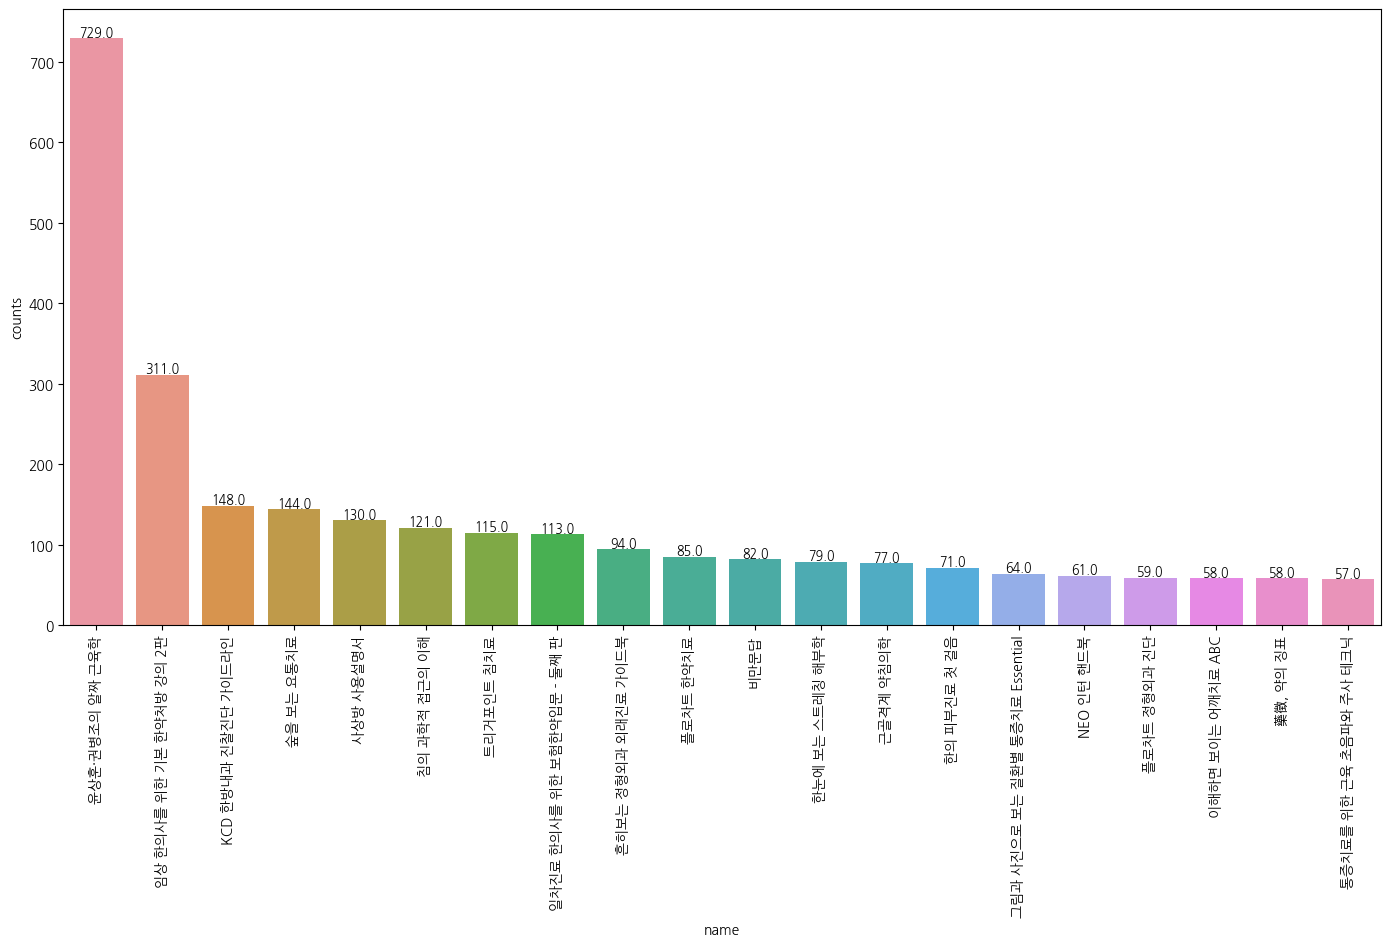

In [38]:
ax = sns.barplot(data=no_promotion_book_best, x='name',y='counts')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

# 베스트셀러 비교: 프로모션 포함 VS 프로모션 제외 

In [39]:
be = bestseller_count_df.rename(columns={'name':'include_promotion'})#.reset_index().sort_values(by='cnt',ascending=False)
af = no_promotion_book_best.rename(columns={'name':'exclude_promotion'})
compare = pd.concat([be,af], axis=1)[['include_promotion', 'exclude_promotion']]
compare

,include_promotion,exclude_promotion
0,윤상훈·권병조의 알짜 근육학,윤상훈·권병조의 알짜 근육학
1,KCD 한방내과 진찰진단 가이드라인,임상 한의사를 위한 기본 한약처방 강의 2판
2,한의 피부진료 첫 걸음,KCD 한방내과 진찰진단 가이드라인
3,사상방 사용설명서,숲을 보는 요통치료
4,그림과 사진으로 보는 질환별 통증치료 Essential,사상방 사용설명서
5,비만문답,침의 과학적 접근의 이해
6,한방처방정석,트리거포인트 침치료
7,일차진료 한의사를 위한 보험한약입문 - 둘째 판,일차진료 한의사를 위한 보험한약입문 - 둘째 판
8,사진으로 공부하는 이비인후과학,흔히보는 정형외과 외래진료 가이드북
9,통장잔고 2배 늘려주는 병의원 절세비법,플로차트 한약치료


In [40]:
# numpy array는 리스트로 만들고 합 연산 가능
inclued = list(compare['include_promotion'].values)
exclued = list(compare['exclude_promotion'].values)

# 프로모션 전처리 후에도 베스트셀러인 도서: intersection
intersection = list(set(inclued) & set(exclued))
print('프로모션 전, 후 모두 베스트셀러: ', len(intersection),'개')
print(intersection)
print()

# 프로모션 전처리 전에만 베스트셀러인 도서
before_complement = list(set(inclued) - set(exclued))
print('프로모션 전처리 전에만 베스트셀러인 도서: ', len(before_complement),'개')
print(before_complement)
print()

# 프로모션 전처리 후에만 베스트셀러인 도서
after_complement = list(set(exclued) - set(inclued))
print('프로모션 전처리 후에만 베스트셀러인 도서: ', len(after_complement),'개')
print(after_complement)
print()

프로모션 전, 후 모두 베스트셀러:  11 개
['KCD 한방내과 진찰진단 가이드라인', '한의 피부진료 첫 걸음', '윤상훈·권병조의 알짜 근육학', '사상방 사용설명서', '근골격계 약침의학', '플로차트 정형외과 진단', '일차진료 한의사를 위한 보험한약입문 - 둘째 판', '藥徵, 약의 징표', '그림과 사진으로 보는 질환별 통증치료 Essential', '비만문답', '침의 과학적 접근의 이해']

프로모션 전처리 전에만 베스트셀러인 도서:  9 개
['임상 한의사를 위한 기본 한약처방 강의(개정판)', '증보운곡본초학', '한방처방정석', '사진으로 공부하는 이비인후과학', '한방치료 44철칙', '말초신경 약침의학', '침의 과학적 접근과 임상활용', '알기 쉬운 이비인후과 한약처방가이드', '통장잔고 2배 늘려주는 병의원 절세비법']

프로모션 전처리 후에만 베스트셀러인 도서:  9 개
['이해하면 보이는 어깨치료 ABC', '임상 한의사를 위한 기본 한약처방 강의 2판', '숲을 보는 요통치료', '흔히보는 정형외과 외래진료 가이드북', '트리거포인트 침치료', '통증치료를 위한 근육 초음파와 주사 테크닉', 'NEO 인턴 핸드북', '한눈에 보는 스트레칭 해부학', '플로차트 한약치료']



* 같은 기간 동안 프로모션 아이템이 포함되었을 때와 포함되지 않았을 때 베스트셀러가 달랐다.
* 프로모션 아이템 구매는 일반적인 구매 행동이 아니라고 판단하여 프로모션 전처리 후의 데이터로 모델 학습을 진행할 예정이다.